In [2]:
# Import tensorflow and keras
import tensorflow

In [3]:
# Check the tensorflow and keras version
print(f' TensowFlow version is {tensorflow.__version__}')

 TensowFlow version is 2.14.0


In [39]:
# Supress warnings
import warnings 
warnings.filterwarnings('ignore')

import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Data manipulation
import numpy as np
import pandas as pd
import datetime
from pathlib import Path

# Sckiti-learn modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Tensorflow modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Plotting outputs
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from pprint import pprint

In [40]:
def set_seeds(seed=2023):
    random.seed(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)

In [6]:
# Create sample dataset
X = np.array([i+1 for i in range(60)])

# Reshape into 3D
X = np.array(X).reshape(20, 3, 1)

print(f'X: {X}')

X: [[[ 1]
  [ 2]
  [ 3]]

 [[ 4]
  [ 5]
  [ 6]]

 [[ 7]
  [ 8]
  [ 9]]

 [[10]
  [11]
  [12]]

 [[13]
  [14]
  [15]]

 [[16]
  [17]
  [18]]

 [[19]
  [20]
  [21]]

 [[22]
  [23]
  [24]]

 [[25]
  [26]
  [27]]

 [[28]
  [29]
  [30]]

 [[31]
  [32]
  [33]]

 [[34]
  [35]
  [36]]

 [[37]
  [38]
  [39]]

 [[40]
  [41]
  [42]]

 [[43]
  [44]
  [45]]

 [[46]
  [47]
  [48]]

 [[49]
  [50]
  [51]]

 [[52]
  [53]
  [54]]

 [[55]
  [56]
  [57]]

 [[58]
  [59]
  [60]]]


In [7]:
# Check sahpe
X.shape

(20, 3, 1)

In [8]:
# y is the sum of the values in the timesteps
y = []
for each in X:
    y.append(each.sum())

# Convert to array
y = np.array(y)

# Check the output
print(f'y: {y}')

y: [  6  15  24  33  42  51  60  69  78  87  96 105 114 123 132 141 150 159
 168 177]


In [9]:
# check the shape
y.shape

(20,)

In [10]:
# compile model five
nn = Sequential()
nn.add(LSTM(50, activation='relu', input_shape=(3, 1)))
nn.add(Dense(1))
nn.compile(optimizer='adam', loss='mse')
print(nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
# fit model
nn.fit(X, y, batch_size=5, epochs=2000, validation_split=0.2, verbose=0)

In [12]:
# predict the outcome
test_input = np.array([70,71,72])
test_input = test_input.reshape((1, 3, 1))
test_output = nn.predict(test_input, verbose=0)
print(test_output)

[[212.69257]]


In [13]:
results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)    

In [66]:
# Read data from the locally stored file
data = pd.read_csv('data/spy.csv', index_col=0, parse_dates=True)[['Adj Close']]['2000':'2019']
data

,Adj Close
Date,
2000-03-01,1455.219971
2000-04-01,1399.420044
2000-05-01,1402.109985
2000-06-01,1403.449951
2000-07-01,1441.469971
...,...
2019-12-24,3223.379883
2019-12-26,3239.909912
2019-12-27,3240.020020


In [67]:
# Check the shape - has to be 2D
data.shape

(5031, 1)

In [68]:
# Check for missing values
data.isna().sum()

Adj Close    0
dtype: int64

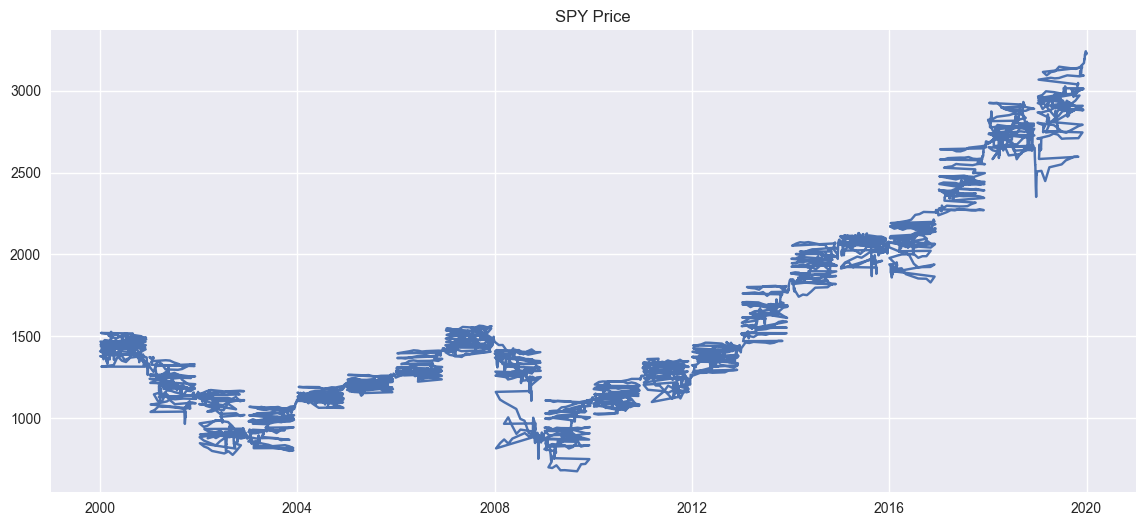

In [69]:
# Visualization
plt.figure(figsize=(14,6))
plt.title('SPY Price')
plt.plot(data);

In [70]:
# Splitting the datasets into training and testing data.
train_data, test_data = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

Train and Test Size 4024, 1007


In [71]:
# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [72]:
def generate_sequence(data, sequence_length=60):
    # create X & y data array
    X = []
    y = []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, 0])
        y.append(data[i, 0])
        
    # Converting x_train and y_train to Numpy arrays
    return np.array(X), np.array(y)

In [73]:
# sequence length
lookback = 60

In [74]:
X_train, y_train = generate_sequence(data=scaled_train_data, sequence_length=lookback)
print(f'X_train: {X_train.shape}, y_train {y_train.shape}')

X_train: (3964, 60), y_train (3964,)


In [75]:
X_test, y_test = generate_sequence(data=scaled_test_data, sequence_length=lookback)
print(f'X_test: {X_test.shape}, y_test {y_test.shape}')

X_test: (947, 60), y_test (947,)


In [76]:
# reshaping array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train[:, np.newaxis]

# check the array size
print(f'X_train Shape: {X_train.shape}, y_train {y_train.shape}')

X_train Shape: (3964, 60, 1), y_train (3964, 1)


In [77]:
# reshaping array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = y_test[:, np.newaxis]

# check the array size
print(f'X_test Shape: {X_test.shape}, y_test {y_test.shape}')

X_test Shape: (947, 60, 1), y_test (947, 1)


In [78]:
# Create a model
def create_model(hu=256, lookback=60):
    tensorflow.keras.backend.clear_session()
    
    # instantiate the model
    model = Sequential()
    model.add(LSTM(units=hu, input_shape=(lookback, 1), activation = 'relu', return_sequences=False, name='LSTM'))
    
    model.add(Dense(units=1, name='Output')) # can also specify linear activation function
    
    # specify optimizer separately (preferred method))
    # opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0) # adam optimizer seems to perform better for a single lstm
    
    # model compilation
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    
    return model

In [79]:
# lstm network
model = create_model(hu=10, lookback=lookback)

In [80]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
plot_model(model, to_file='./img/model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [82]:
# Specify callback functions
model_path = (results_path / 'model.h5').as_posix()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
                ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
                TensorBoard(log_dir=logdir, histogram_freq=1)]

In [83]:
# Model fitting
lstm_training = model.fit(X_train, 
                          y_train,
                          batch_size=64,
                          epochs=500,
                          verbose=1,
                          callbacks=my_callbacks,
                          shuffle=False)

Epoch 1/500
61/62 [============================>.] - ETA: 0s - loss: 0.0242 - mae: 0.1165
Epoch 1: loss improved from inf to 0.02380, saving model to results/lstm_time_series\model.h5
62/62 [==============================] - 3s 26ms/step - loss: 0.0238 - mae: 0.1152
Epoch 2/500
59/62 [===========================>..] - ETA: 0s - loss: 0.0024 - mae: 0.0400
Epoch 2: loss improved from 0.02380 to 0.00243, saving model to results/lstm_time_series\model.h5
62/62 [==============================] - 1s 21ms/step - loss: 0.0024 - mae: 0.0404
Epoch 3/500
61/62 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0372
Epoch 3: loss improved from 0.00243 to 0.00189, saving model to results/lstm_time_series\model.h5
62/62 [==============================] - 1s 21ms/step - loss: 0.0019 - mae: 0.0371
Epoch 4/500
61/62 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0289
Epoch 4: loss improved from 0.00189 to 0.00121, saving model to results/lstm_time_series\model.h5
62/

In [84]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [85]:
# calculate rmse of loss function
train_rmse_scaled = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

Train RMSE: 0.0312 | Test RMSE: 0.0210


In [86]:
# predictions
y_pred = model.predict(X_test)

30/30 [==============================] - 0s 6ms/step


In [87]:
df = pd.DataFrame({'actual': scaler.inverse_transform(y_test).flatten(),
                   'prediction': scaler.inverse_transform(y_pred).flatten()},
                  index = test_data[lookback:].index)
df['spread'] = df['prediction'] - df['actual']
df

,actual,prediction,spread
Date,,,
2016-03-30,2063.949951,2063.119629,-0.830322
2016-03-31,2059.739990,2068.306885,8.566895
2016-01-04,2072.780029,2071.049316,-1.730713
2016-04-04,2066.129883,2076.476562,10.346679
2016-05-04,2045.170044,2078.625977,33.455933
...,...,...,...
2019-12-24,3223.379883,3222.542725,-0.837158
2019-12-26,3239.909912,3228.745850,-11.164062
2019-12-27,3240.020020,3238.504150,-1.515870


In [88]:
print(f'R-square: {r2_score(df.actual, df.prediction):0.4}')

R-square: 0.9901


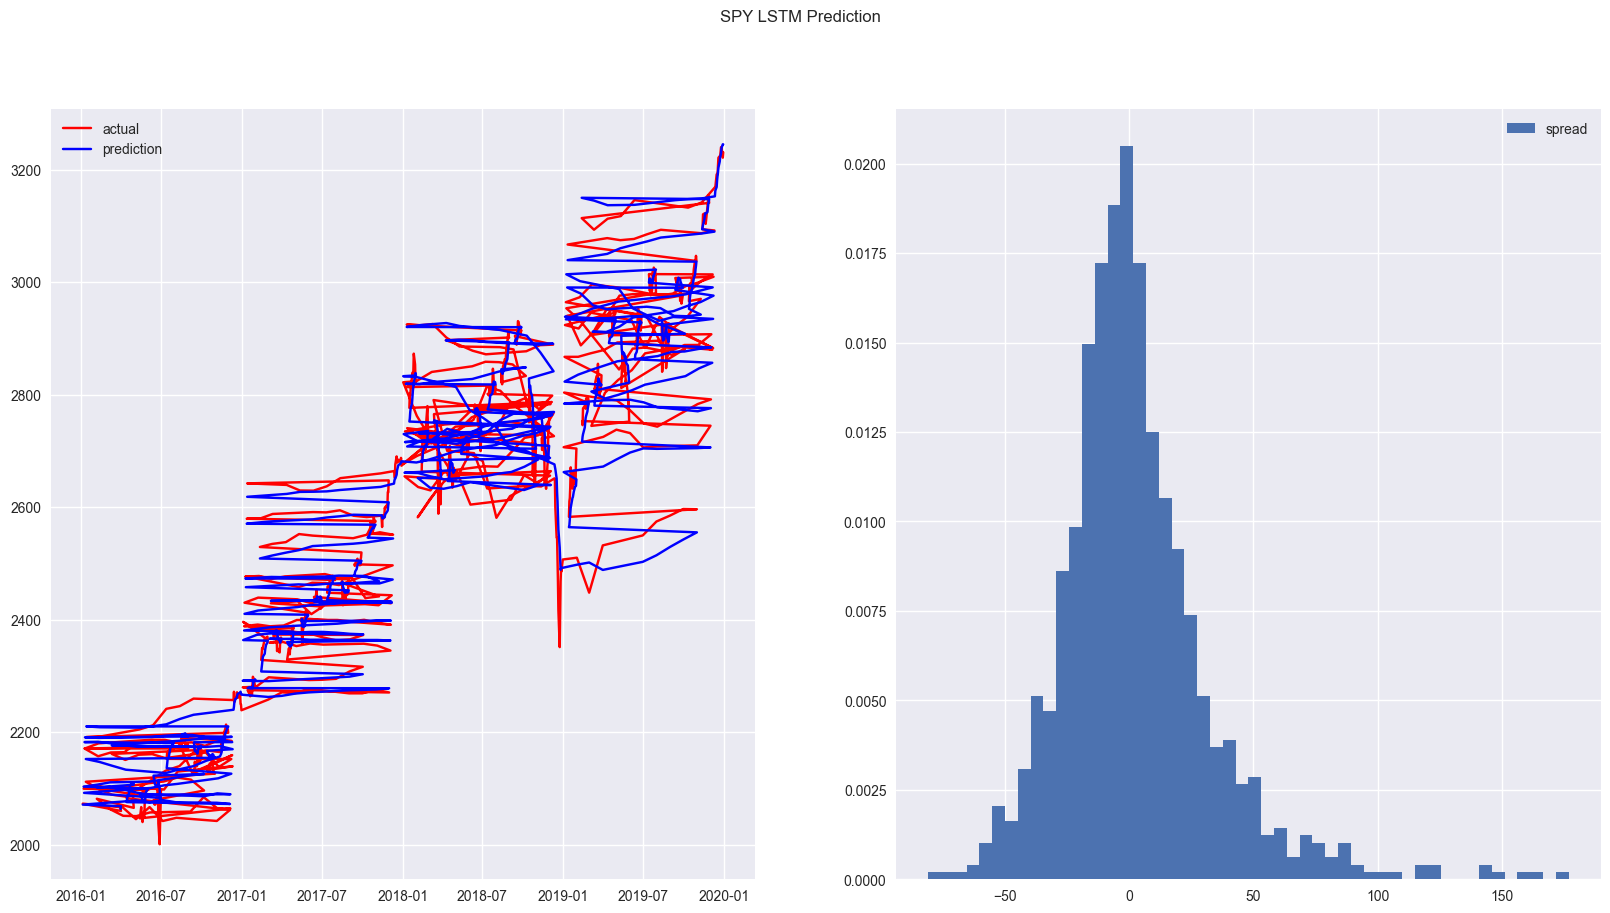

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].plot(df.actual, color='red', label='actual')
ax[0].plot(df.prediction, color='blue', label='prediction')
ax[1].hist(df.spread, bins=50, density=True, label='spread')
ax[0].legend()
ax[1].legend()
plt.suptitle('SPY LSTM Prediction');

<Axes: xlabel='Date'>

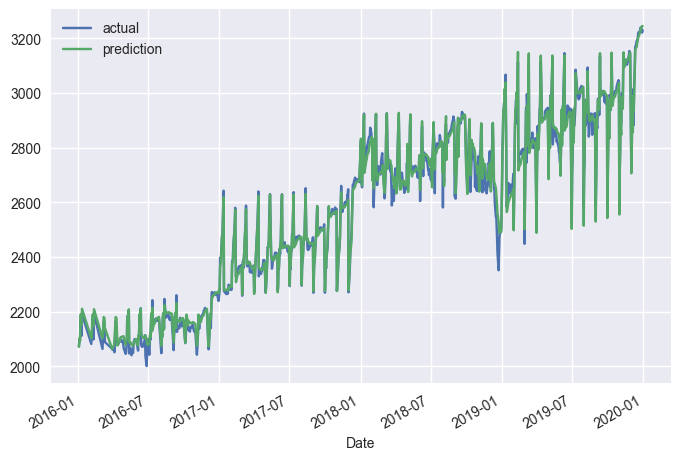

In [93]:
df[['actual', 'prediction']].plot()